In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import random
import time
from matplotlib.animation import FuncAnimation
import time

class SpectrumEnvironment:
    def __init__(self, num_bands=10, steps=25):
        self.num_bands = num_bands  # Total number of frequency bands
        self.steps = steps
        self.channel_states = [[] for _ in range(num_bands)]
        self.transition_matrices = self._initialize_transition_matrices()
        self.state = self._generate_spectrum_state()  # Current state of the spectrum
        self.total_reward = 0  # Track total reward
        self.rewards = []  # Track rewards for each step
        self.energy_costs = [[] for _ in range(num_bands)]

    def _initialize_transition_matrices(self):
        """
        Generate a unique random Markov chain transition matrix for each band.
        Each matrix ensures that the probabilities in each row sum to 1.
        """
        matrices = []
        for _ in range(self.num_bands):
            # Generate a random 2x2 matrix
            random_matrix = np.random.rand(2, 2)
            # Normalize each row to sum to 1
            transition_matrix = random_matrix / random_matrix.sum(axis=1, keepdims=True)
            matrices.append(transition_matrix)
        return matrices

    def _generate_spectrum_state(self):
        """
        Generate a spectrum state using Markov chain dynamics for each band.
        Each band has a distinct transition matrix and evolves over 'steps' timesteps.
        """
        new_states = []

        for band in range(self.num_bands):
            # Get the last state or default to 0 if no history exists
            last_state = self.channel_states[band][-1] if self.channel_states[band] else 0

            # Generate states for the next 'steps' timesteps using the Markov chain
            band_states = []
            for _ in range(self.steps):
                # Determine the next state based on the Markov chain
                transition_probabilities = self.transition_matrices[band][last_state]
                next_state = np.random.choice([0, 1], p=transition_probabilities)
                band_states.append(next_state)
                last_state = next_state  # Update for the next step

            # Append the generated states to history
            self.channel_states[band] = band_states
        return self.channel_states
    
    def energy_detection(self, time_step, band, delta=0.1):
        """
        Perform energy detection for a specific band and timestep.
        Calculates energy dynamically and assigns rewards based on the state and energy detection.

        Parameters:
        - time_step (int): The timestep to evaluate.
        - band (int): The band (channel) number to evaluate.
        - delta (float): The change in energy state for transitions (default: 0.1).

        Returns:
        - reward (int): The reward calculated based on energy detection and the channel state.
        """
        # Ensure the inputs are within valid ranges
        if not (0 <= band < self.num_bands):
            raise ValueError("Band number out of range.")
        if not (0 <= time_step < self.steps):
            raise ValueError("Time step out of range.")

        # Current state of the channel
        current_state = self.channel_states[band][time_step]

        # Retrieve previous energy state (default to 0 if no previous energy state)
        previous_energy = self.energy_costs[band][-1] if len(self.energy_costs[band]) > 0  else 0

        # Calculate new energy state
        if current_state == 1:
            # Increase energy by delta if the state is 1
            new_energy = previous_energy + delta
        else:
            # No change in energy if the state is 0
            new_energy = previous_energy

        self.energy_costs[band].append(new_energy)
        return new_energy

    def matched_filter_fft(self, band, time_step):
        """
        Simulates matched filter detection using FFT with adaptive energy consumption.
        Energy consumption is higher for detecting occupied states (state = 1).
        
        Parameters:
        - band (int): The band (channel) to evaluate.
        - time_step (int): The time step for the evaluation.

        Returns:
        - energy_consumption (float): The energy consumed by the matched filter detection.
        """
        # Ensure inputs are valid
        if not (0 <= band < self.num_bands):
            raise ValueError("Band number out of range.")
        if not (0 <= time_step < self.steps):
            raise ValueError("Time step out of range.")

        # Current state of the channel
        current_state = self.channel_states[band][time_step]

        # Base energy consumption for matched filter detection
        base_energy = 0.2

        # Additional energy cost based on the state (higher for state = 1)
        state_energy = 0.1 if current_state == 1 else 0.05

        # Add an energy cost for history length as in a Markov process
        sensing_history_length = len(self.energy_costs[band])
        history_energy = 0.02 * sensing_history_length

        # Total energy consumption
        total_energy_consumption = base_energy + state_energy + history_energy

        # Update energy costs history for this band
        self.energy_costs[band].append(total_energy_consumption)

        return total_energy_consumption


    def cyclostationary_detection(self, band, time_step):
        """
        Simulates cyclostationary feature detection based on periodic properties.
        Energy consumption is moderate and depends on the band state and history.
        
        Parameters:
        - band (int): The band (channel) to evaluate.
        - time_step (int): The time step for the evaluation.

        Returns:
        - energy_consumption (float): The energy consumed by cyclostationary detection.
        """
        # Ensure inputs are valid
        if not (0 <= band < self.num_bands):
            raise ValueError("Band number out of range.")
        if not (0 <= time_step < self.steps):
            raise ValueError("Time step out of range.")

        # Current state of the channel
        current_state = self.channel_states[band][time_step]

        # Base energy consumption for cyclostationary detection
        base_energy = 0.15

        # Additional energy cost based on the state (higher for state = 1)
        state_energy = 0.07 if current_state == 1 else 0.03

        # Add an energy cost for history length as in a Markov process
        sensing_history_length = len(self.energy_costs[band])
        history_energy = 0.015 * sensing_history_length

        # Total energy consumption
        total_energy_consumption = base_energy + state_energy + history_energy

        # Update energy costs history for this band
        self.energy_costs[band].append(total_energy_consumption)

        return total_energy_consumption



    def step(self, time_step, band):
        """
        Calculate the reward based on the state of a given channel at a specific timestep.
        
        Parameters:
        - time_step (int): The time step to evaluate.
        - band (int): The band (channel) number to evaluate.
        
        Returns:
        - reward (int): The reward gained from the channel's state at the specified time step.
        """
        # Ensure the inputs are within valid ranges
        if not (0 <= band < self.num_bands):
            raise ValueError("Band number out of range.")
        if not (0 <= time_step < self.steps):
            raise ValueError("Time step out of range.")

        # Get the state of the specified channel at the given timestep
        state = self.channel_states[band][time_step]

        # Calculate the reward
        reward = 30 if state == 0 else -15

        # Update the total reward and track the step reward
        self.total_reward += reward
        self.rewards.append(reward)

        return reward

In [14]:
# Initialize environment
env = SpectrumEnvironment(num_bands=10, steps=50)

# Generate states for all bands
env._generate_spectrum_state()

# Store rewards, actions, and energy costs for visualization
rewards_over_time = []
actions_over_time = []
energy_costs = [[0 for _ in range(env.steps)] for _ in range(env.num_bands)]  # Initialize with None

# Simulate over timesteps
for t in range(env.steps):
    # Perform energy detection
    for selected_band in range(env.num_bands):
        energy = env.cyclostationary_detection(selected_band, t)

time_steps = np.arange(env.steps)

for i in range(env.num_bands): 
    print(env.energy_costs[i])


[0.22, 0.195, 0.25, 0.265, 0.28, 0.295, 0.27, 0.325, 0.33999999999999997, 0.315, 0.37, 0.345, 0.36, 0.41500000000000004, 0.43, 0.40499999999999997, 0.45999999999999996, 0.475, 0.49, 0.46499999999999997, 0.48, 0.535, 0.51, 0.565, 0.58, 0.595, 0.61, 0.625, 0.6, 0.655, 0.6299999999999999, 0.6849999999999999, 0.6599999999999999, 0.715, 0.69, 0.745, 0.72, 0.7749999999999999, 0.7899999999999999, 0.7649999999999999, 0.82, 0.835, 0.85, 0.825, 0.8399999999999999, 0.855, 0.9099999999999999, 0.9249999999999999, 0.8999999999999999, 0.955]
[0.22, 0.195, 0.21, 0.22499999999999998, 0.24, 0.295, 0.31, 0.325, 0.33999999999999997, 0.355, 0.32999999999999996, 0.345, 0.36, 0.375, 0.39, 0.40499999999999997, 0.42, 0.475, 0.49, 0.505, 0.48, 0.495, 0.51, 0.5249999999999999, 0.58, 0.5549999999999999, 0.5700000000000001, 0.585, 0.6, 0.615, 0.6299999999999999, 0.645, 0.7, 0.715, 0.73, 0.7050000000000001, 0.72, 0.7349999999999999, 0.7899999999999999, 0.7649999999999999, 0.78, 0.7949999999999999, 0.81, 0.825, 0.83

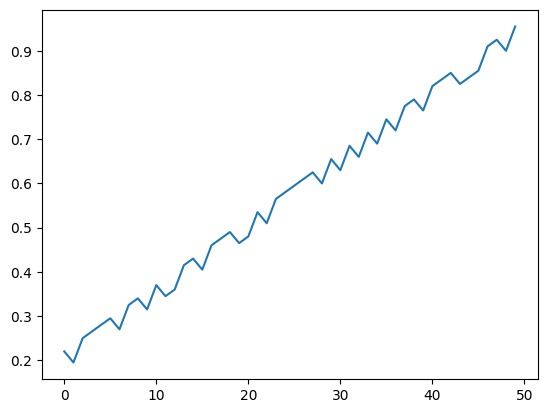

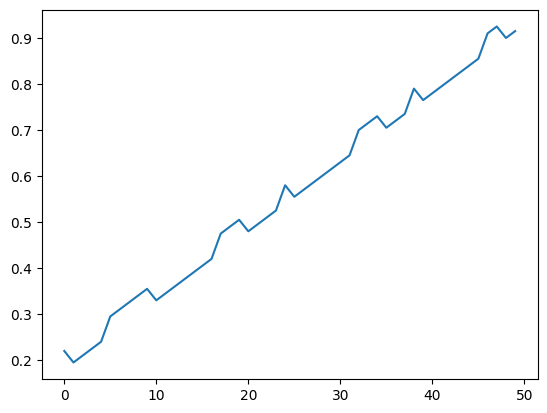

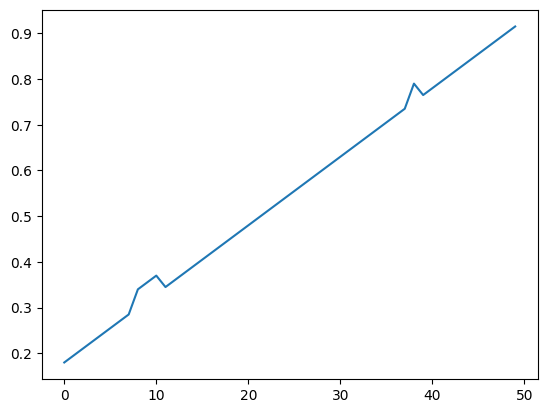

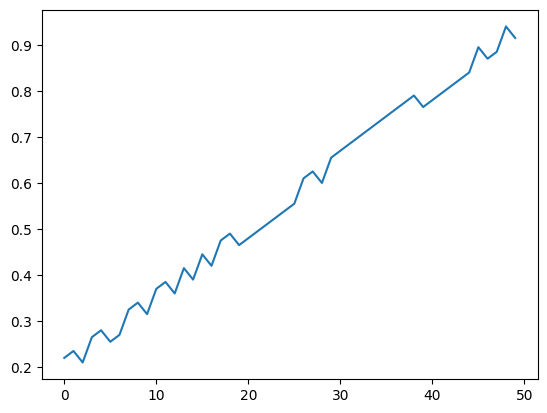

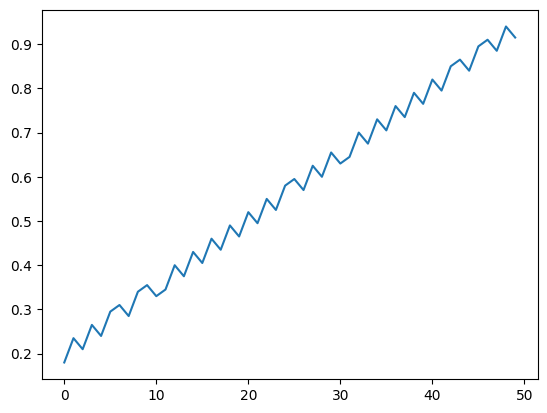

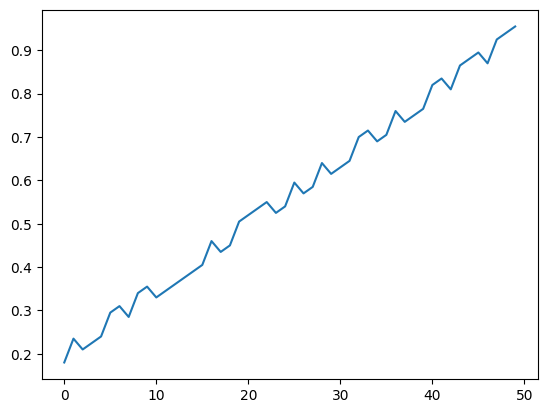

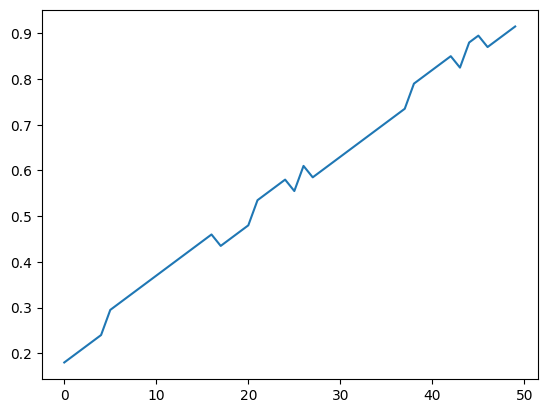

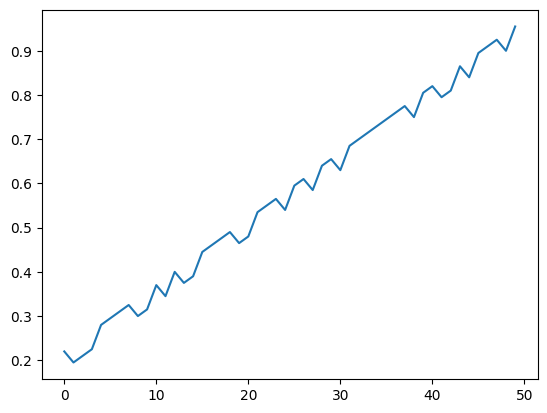

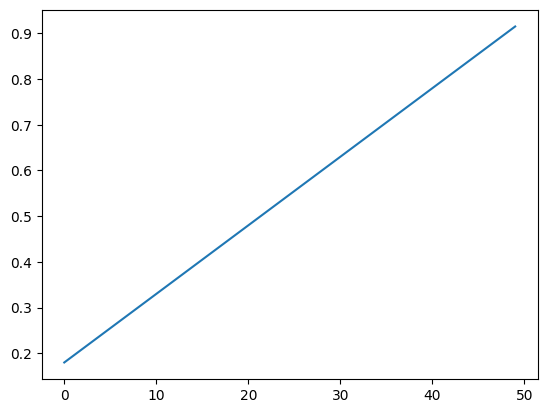

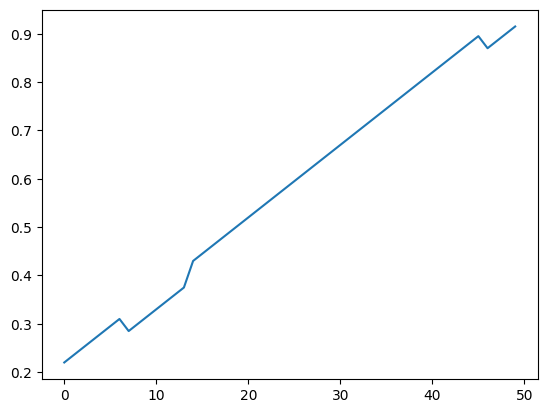

In [15]:

for i in range(env.num_bands):
    plt.plot(range(env.steps), env.energy_costs[i])
    plt.show()
    plt.close()

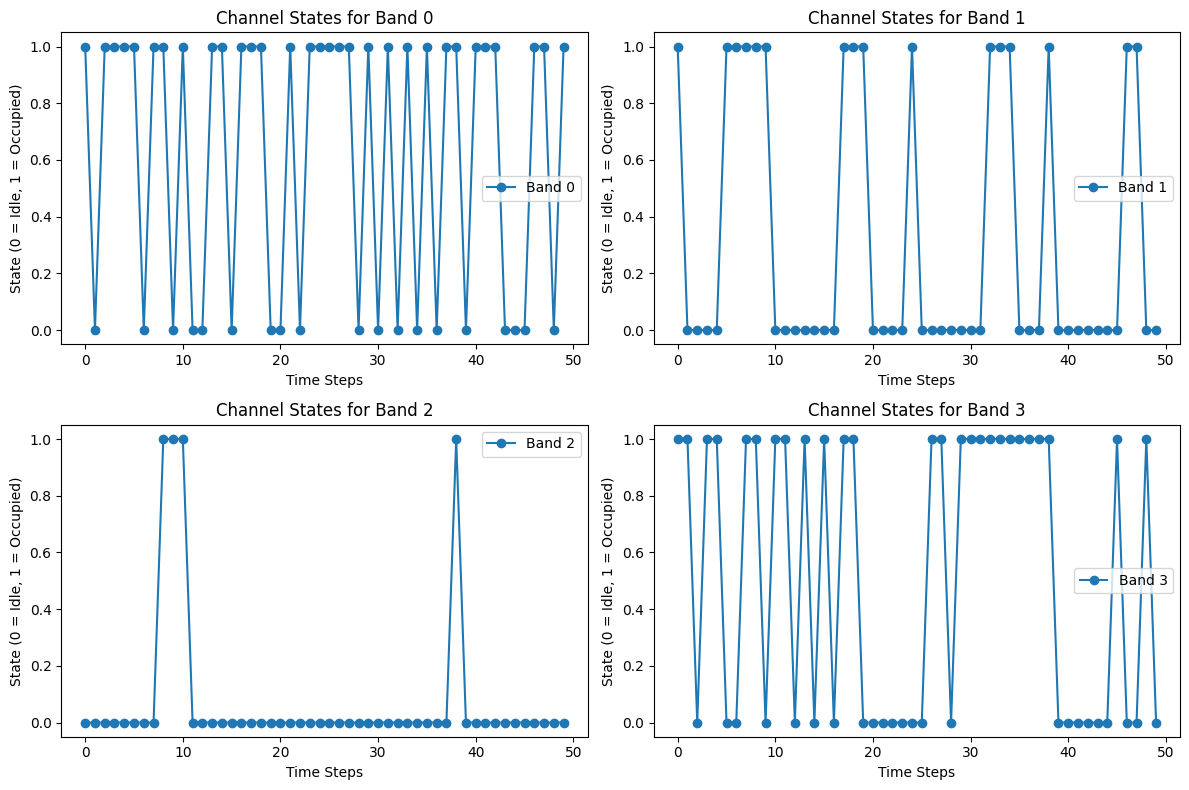

In [16]:
# Visualization of channel states for 4 selected bands
fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # Create a 2x2 grid of subplots
selected_bands = [0, 1, 2, 3]  # Indices of bands to visualize

for i, band in enumerate(selected_bands):
    ax = axes[i // 2, i % 2]  # Access subplot in 2x2 grid
    states = [env.channel_states[band][t] for t in range(env.steps)]
    ax.plot(time_steps, states, label=f"Band {band}", marker='o')
    ax.set_xlabel("Time Steps")
    ax.set_ylabel("State (0 = Idle, 1 = Occupied)")
    ax.set_title(f"Channel States for Band {band}")
    ax.legend()

plt.tight_layout()
plt.show()
